# Chicken vs Duck Classification using CNN

In [1]:
!pip install torchvision

  Using cached torchvision-0.21.0-cp310-cp310-win_amd64.whl (1.6 MB)
  Using cached torch-2.6.0-cp310-cp310-win_amd64.whl (204.2 MB)
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Uninstalling sympy-1.11.1:
      Successfully uninstalled sympy-1.11.1
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1


In [1]:
import os
import time
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

In [2]:
CHICKEN_IMAGES_PATH = "./data/chicken-images/data"
DUCK_IMAGES_PATH = "./data/duck-images/data"

chicken_images_dir = glob.glob(f"{CHICKEN_IMAGES_PATH}/train/*")
duck_images_dir = glob.glob(f"{DUCK_IMAGES_PATH}/train/*")

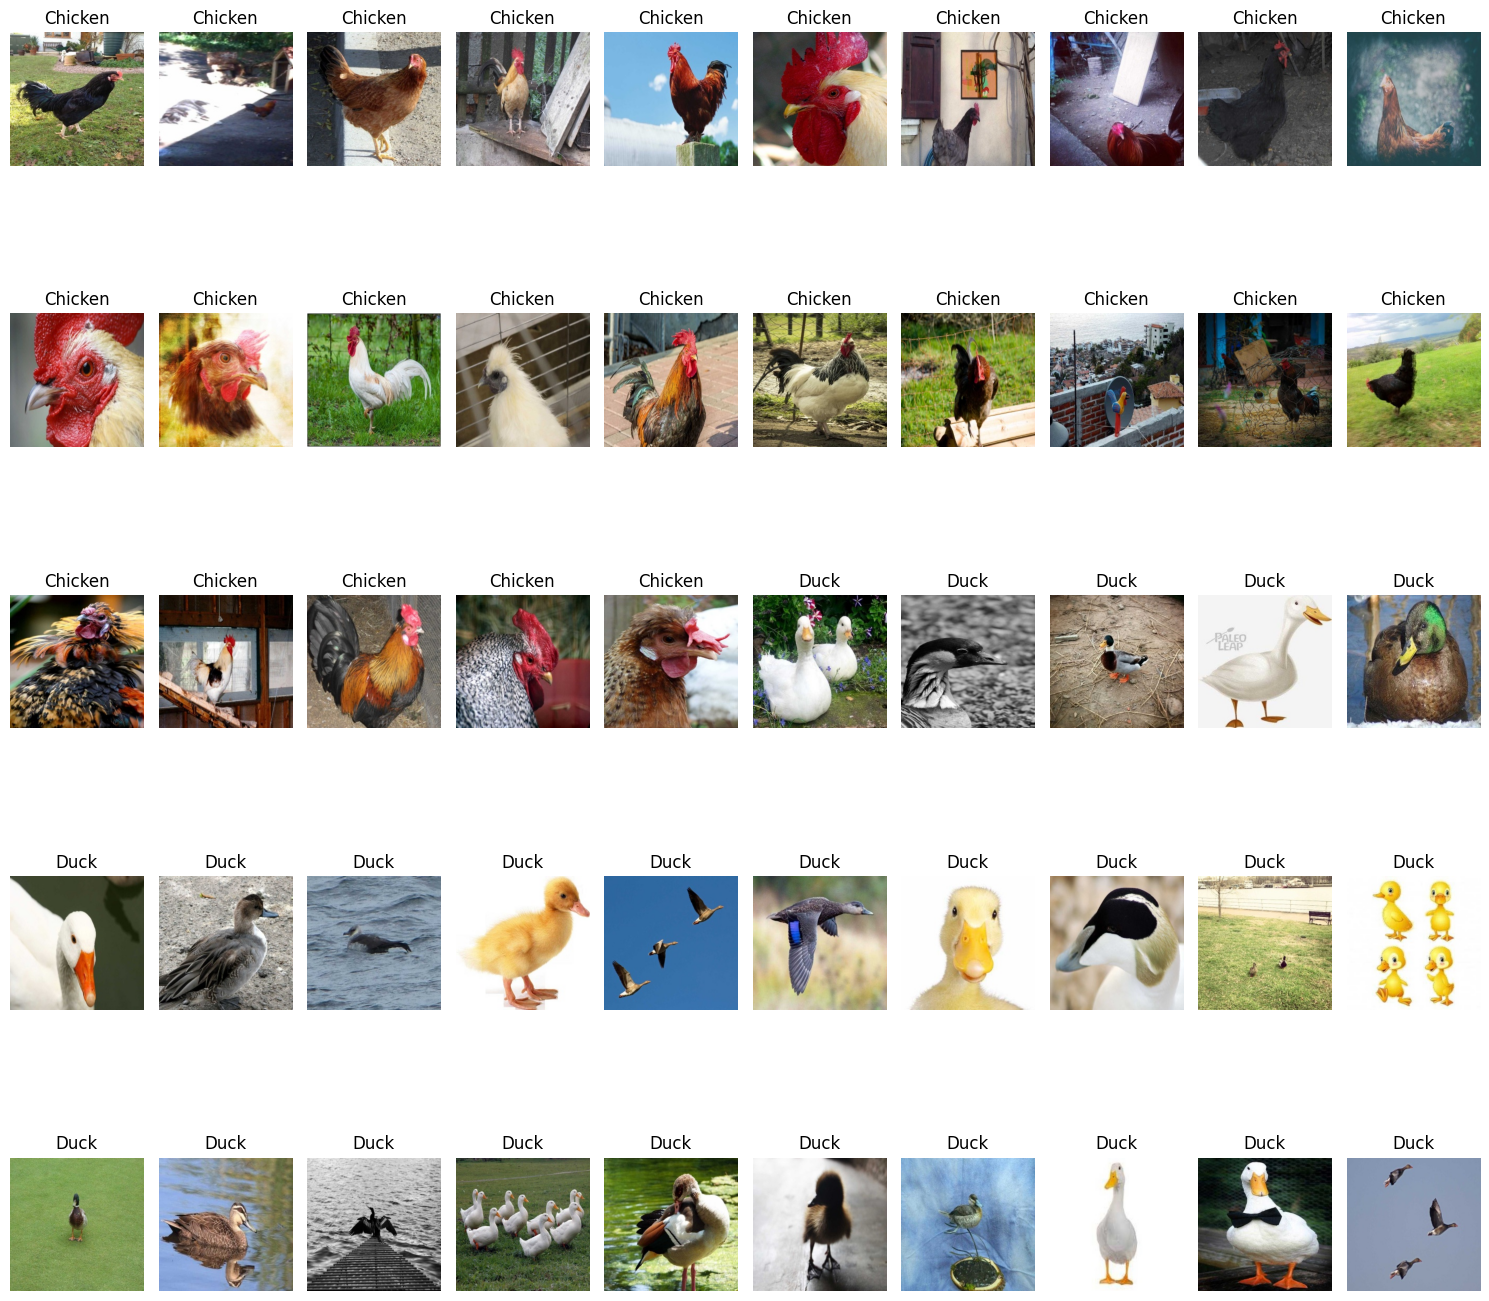

In [3]:
# Random sampling (assuming chicken_images_dir and duck_images_dir are lists of file paths)
random.seed(9)
chicken = random.sample(chicken_images_dir, k=min(25, len(chicken_images_dir)))
duck = random.sample(duck_images_dir, k=min(25, len(duck_images_dir)))

# Combine and label the images
samples = [(img, "Chicken") for img in chicken] + [(img, "Duck") for img in duck]
total_samples = len(samples)

# Calculate grid size
cols = 10
rows = (total_samples + cols - 1) // cols  # ceil division

fig, ax = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for idx, (img_path, label) in enumerate(samples):
    r = idx // cols
    c = idx % cols
    ax[r, c].imshow(Image.open(img_path))
    ax[r, c].axis("off")
    ax[r, c].set_title(label)

# Hide any unused subplots
for idx in range(len(samples), rows * cols):
    r = idx // cols
    c = idx % cols
    ax[r, c].axis("off")

plt.tight_layout()
plt.show()

In [4]:
# Function to create annotations
def create_annotations_file(paths: list[str]):
    train, val, test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    for path in paths:
        label = path.split("/")[-2]
        for split, df in zip(["train", "val", "test"], [train, val, test]):
            folder = os.path.join(path, split)
            files = [f"{folder}/{f}" for f in os.listdir(folder)]
            temp = pd.DataFrame({"path": files, "class": label})
            if split == "train":
                train = pd.concat([train, temp])
            elif split == "val":
                val = pd.concat([val, temp])
            else:
                test = pd.concat([test, temp])

    return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

train, val, test = create_annotations_file([CHICKEN_IMAGES_PATH, DUCK_IMAGES_PATH])

#### Pie charts for class distribution

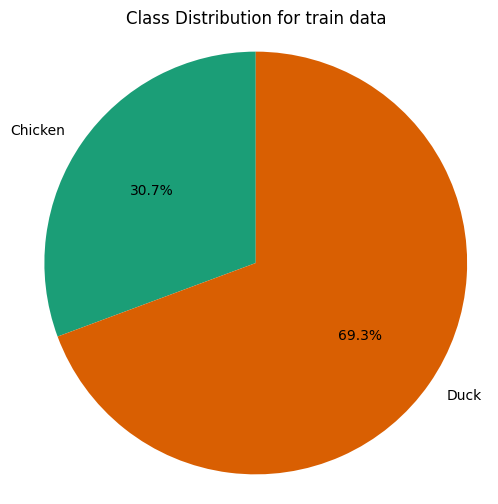

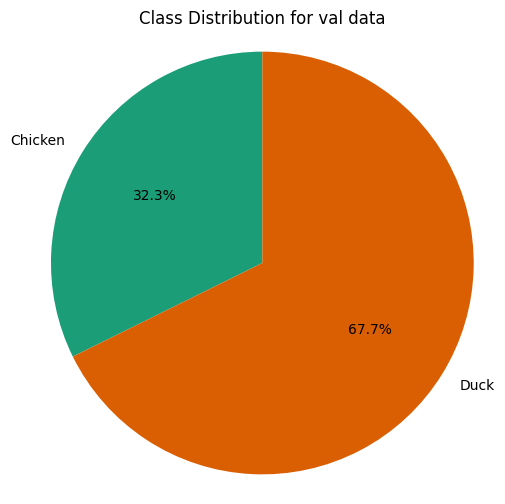

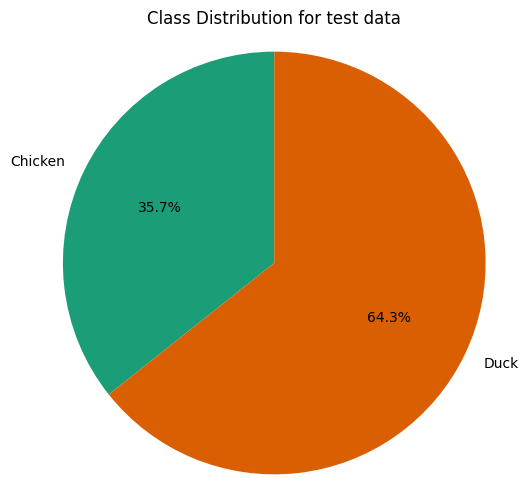

In [5]:
for split_name, split_df in [("train", train), ("val", val), ("test", test)]:
    class_counts = split_df.groupby("class").size()
    class_labels = ["Chicken" if label == "chicken-images" else "Duck" for label in class_counts.index]
    
    plt.figure(figsize=(6, 6))
    plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Dark2")[:len(class_labels)])
    plt.title(f"Class Distribution for {split_name} data")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [6]:
# Custom Dataset
class ChickenOrDuck(Dataset):
    def __init__(self, annotations_file, transforms):
        self.annotations_file = annotations_file
        self.transforms = transforms

    def __getitem__(self, index):
        image_path = self.annotations_file.loc[index, "path"]
        label_str = self.annotations_file.loc[index, "class"]
        label = 1 if label_str == "chicken-images" else 0

        image = Image.open(image_path).convert("RGB")
        image = image.resize((256, 256))
        image = self.transforms(image)
        return image, label

    def __len__(self):
        return len(self.annotations_file)

#### Transforming images

In [7]:
# Preprocessing
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

image_transforms = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
}

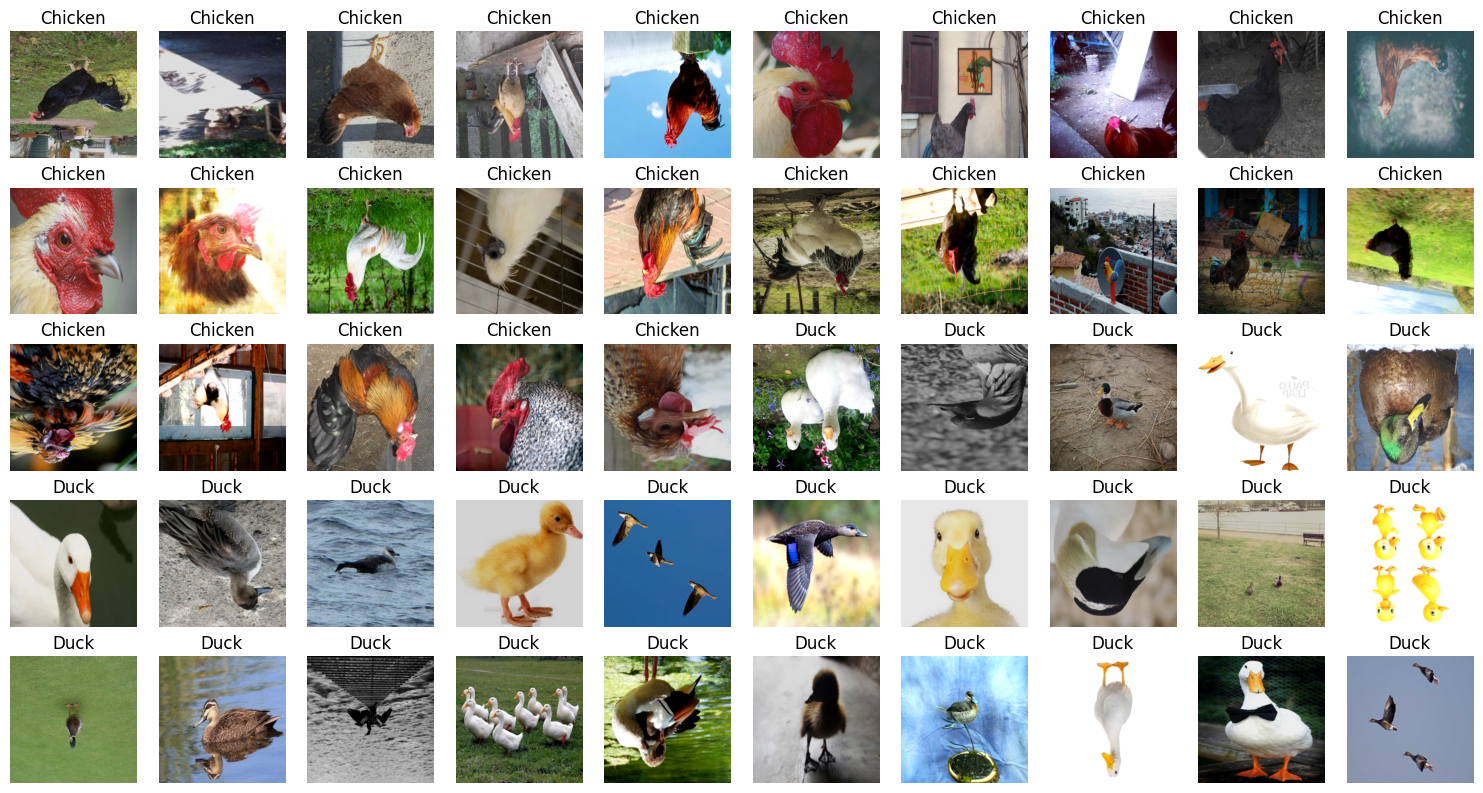

In [8]:
# Random sampling (assuming chicken_images_dir and duck_images_dir are lists of file paths)
random.seed(9)
chicken = random.sample(chicken_images_dir, k=min(25, len(chicken_images_dir)))
duck = random.sample(duck_images_dir, k=min(25, len(duck_images_dir)))

# Combine and label the images
samples = [(img, "Chicken") for img in chicken] + [(img, "Duck") for img in duck]
total_samples = len(samples)

# Define a function to unnormalize and plot the image
def unnormalize(tensor, mean, std):
    # Denormalize the image tensor back to [0, 1] range
    for i in range(3):  # Assuming 3 channels (RGB)
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor.clamp(0, 1)  # Ensure the values are in [0, 1] range

# Apply the transformations and visualize
fig, ax = plt.subplots(5, 10, figsize=(15, 8))
for idx, (img_path, label) in enumerate(samples):
    r = idx // 10
    c = idx % 10

    # Apply transformations to the image
    img = Image.open(img_path).convert("RGB")
    transformed_img = image_transforms["train"](img)
    
    # Unnormalize the image before displaying
    unnormalized_img = unnormalize(transformed_img, mean, std)
    
    # Plot the unnormalized image
    ax[r, c].imshow(unnormalized_img.permute(1, 2, 0))  # Convert from tensor format to image format (H, W, C)
    ax[r, c].axis("off")
    ax[r, c].set_title(label)

plt.tight_layout()
plt.show()

In [9]:
# Datasets and Dataloaders
train_dataset = ChickenOrDuck(train, image_transforms["train"])
val_dataset = ChickenOrDuck(val, image_transforms["val"])
test_dataset = ChickenOrDuck(test, image_transforms["val"])

BATCH_SIZE = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Using device: cpu


In [10]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_path = os.path.join(tempdir, "best.pt")
        torch.save(model.state_dict(), best_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}\n{'-'*50}")
            for phase in ["train", "val"]:
                model.train() if phase == "train" else model.eval()
                dataloader = train_dataloader if phase == "train" else val_dataloader
                running_loss, running_corrects = 0.0, 0

                for inputs, labels in dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                scheduler.step()

                epoch_loss = running_loss / len(dataloader.dataset)
                epoch_acc = running_corrects.double() / len(dataloader.dataset)
                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_path)

        print(f"\nTraining complete in {(time.time()-since)//60:.0f}m {(time.time()-since)%60:.0f}s")
        print(f"Best val Acc: {best_acc:.4f}")
        model.load_state_dict(torch.load(best_path))
    return model

In [11]:
# Load pre-trained ResNet18
model_ft = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
--------------------------------------------------
train Loss: 0.3463 Acc: 0.8439
val Loss: 0.2202 Acc: 0.9068
Epoch 2/15
--------------------------------------------------
train Loss: 0.1673 Acc: 0.9353
val Loss: 0.1882 Acc: 0.9255
Epoch 3/15
--------------------------------------------------
train Loss: 0.1010 Acc: 0.9643
val Loss: 0.1812 Acc: 0.9068
Epoch 4/15
--------------------------------------------------
train Loss: 0.0984 Acc: 0.9688
val Loss: 0.2283 Acc: 0.9193
Epoch 5/15
--------------------------------------------------
train Loss: 0.0637 Acc: 0.9799
val Loss: 0.1696 Acc: 0.9255
Epoch 6/15
--------------------------------------------------
train Loss: 0.0826 Acc: 0.9688
val Loss: 0.2272 Acc: 0.9193
Epoch 7/15
--------------------------------------------------
train Loss: 0.0670 Acc: 0.9721
val Loss: 0.1596 Acc: 0.9441
Epoch 8/15
--------------------------------------------------
train Loss: 0.0663 Acc: 0.9810
val Loss: 0.1545 Acc: 0.9441
Epoch 9/15
-------------

#### Classification report

In [12]:
# Evaluation
def get_predictions(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels.extend(lbls.numpy())
    return preds, labels

predictions, true_labels = get_predictions(model_ft, test_dataloader, device)
print("\nClassification Report\n")
print(classification_report(true_labels, predictions, target_names=["Duck", "Chicken"]))


Classification Report

              precision    recall  f1-score   support

        Duck       0.96      0.99      0.98       310
     Chicken       0.99      0.92      0.95       172

    accuracy                           0.97       482
   macro avg       0.97      0.96      0.97       482
weighted avg       0.97      0.97      0.97       482



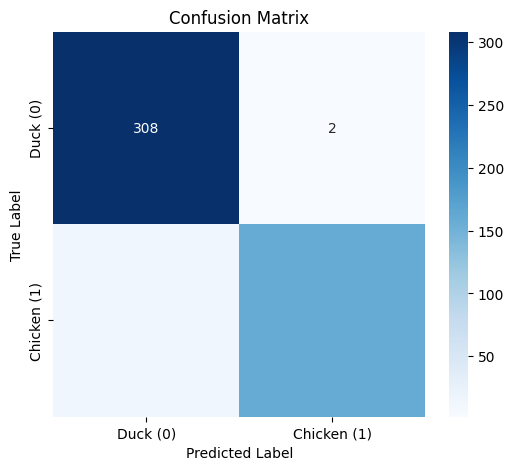

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['Duck (0)', 'Chicken (1)']

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()